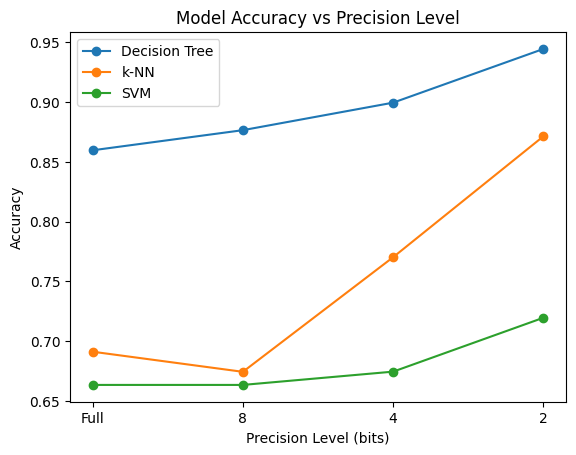

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np

# Load the data
data = load_wine().data
target = load_wine().target

# Quantization function
def quantize_data(data, bits):
    levels = 2 ** bits
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    quantized_data = np.round(((data - min_val) / (max_val - min_val)) * (levels - 1)) * (max_val - min_val) / (levels - 1) + min_val
    return quantized_data

# Quantize data at different precision levels
data_8bit = quantize_data(data, 8)
data_4bit = quantize_data(data, 4)
data_2bit = quantize_data(data, 2)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'k-NN': KNeighborsClassifier(),
    'SVM': SVC()
}

# Initialize dictionaries to store accuracy scores
accuracy_full = {}
accuracy_8bit = {}
accuracy_4bit = {}
accuracy_2bit = {}

# Calculate and store full-precision accuracies
for name, model in models.items():
    accuracy_full[name] = cross_val_score(model, data, target, cv=5).mean()

# Calculate and store accuracies for quantized data
for name, model in models.items():
    accuracy_8bit[name] = cross_val_score(model, data_8bit, target, cv=5).mean()
    accuracy_4bit[name] = cross_val_score(model, data_4bit, target, cv=5).mean()
    accuracy_2bit[name] = cross_val_score(model, data_2bit, target, cv=5).mean()

# Organize the accuracies for plotting
precision_levels = ['Full', 8, 4, 2]
model_accuracies = {
    'Decision Tree': [accuracy_full['Decision Tree'], accuracy_8bit['Decision Tree'], accuracy_4bit['Decision Tree'], accuracy_2bit['Decision Tree']],
    'k-NN': [accuracy_full['k-NN'], accuracy_8bit['k-NN'], accuracy_4bit['k-NN'], accuracy_2bit['k-NN']],
    'SVM': [accuracy_full['SVM'], accuracy_8bit['SVM'], accuracy_4bit['SVM'], accuracy_2bit['SVM']]
}

# Plot the results
import matplotlib.pyplot as plt

for model, accuracies in model_accuracies.items():
    plt.plot(precision_levels, accuracies, marker='o', label=model)

plt.xlabel('Precision Level (bits)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Precision Level')
plt.legend()
plt.show()


In [5]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def quantized_sgd_update(gradient, bits):
    levels = 2 ** bits
    step = 1 / (levels - 1)
    stochastic_gradient = np.floor(gradient / step + np.random.rand(*gradient.shape)) * step
    return stochastic_gradient

class QuantizedSGDClassifier(SGDClassifier):
    def __init__(self, bits=2, **kwargs):
        super().__init__(**kwargs)
        self.bits = bits

    def _fit_one_epoch(self, X, y, coef, intercept, alpha, C, sample_weight):
        for i in range(X.shape[0]):
            gradient = self._compute_gradient(X[i:i+1], y[i:i+1], coef, intercept, alpha, C)
            
            quantized_gradient = quantized_sgd_update(gradient, self.bits)
            
            coef -= quantized_gradient
            intercept -= quantized_gradient
            
            super()._partial_fit(X[i:i+1], y[i:i+1], alpha=alpha, C=C,
                                 loss=self.loss, learning_rate=self.learning_rate, 
                                 max_iter=1, sample_weight=sample_weight)

full_precision_model = SGDClassifier(loss='log_loss', max_iter=100000, tol=1e-3, random_state=42)
full_precision_model.fit(X_train, y_train)
full_precision_predictions = full_precision_model.predict(X_test)
full_precision_accuracy = accuracy_score(y_test, full_precision_predictions)

print(f"Full-precision Logistic Regression Accuracy: {full_precision_accuracy:.4f}")

for bits in [2, 4, 8]:
    quantized_model = QuantizedSGDClassifier(loss='log_loss', max_iter=100000, tol=1e-3, random_state=42, bits=bits)
    quantized_model.fit(X_train, y_train)
    quantized_predictions = quantized_model.predict(X_test)
    quantized_accuracy = accuracy_score(y_test, quantized_predictions)
    
    print(f"Quantized Gradient Logistic Regression Accuracy ({bits}-bit): {quantized_accuracy:.4f}")


Full-precision Logistic Regression Accuracy: 0.9298
Quantized Gradient Logistic Regression Accuracy (2-bit): 0.9298
Quantized Gradient Logistic Regression Accuracy (4-bit): 0.9298
Quantized Gradient Logistic Regression Accuracy (8-bit): 0.9298
